In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Загрузка и обработка данных

In [71]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [7]:
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [8]:
test.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


In [9]:
sub.head()

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0


In [10]:
train.shape, test.shape

((5000000, 3), (2000000, 2))

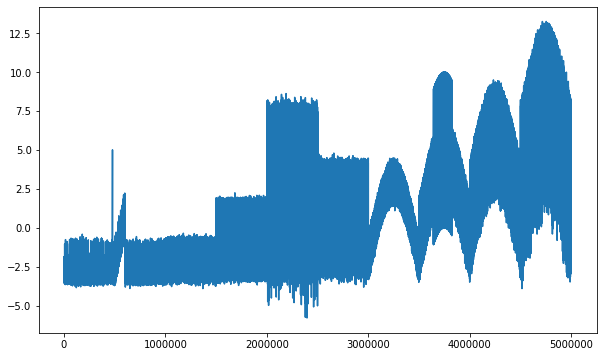

In [14]:
train.signal.plot(figsize=(10,6))
plt.show()

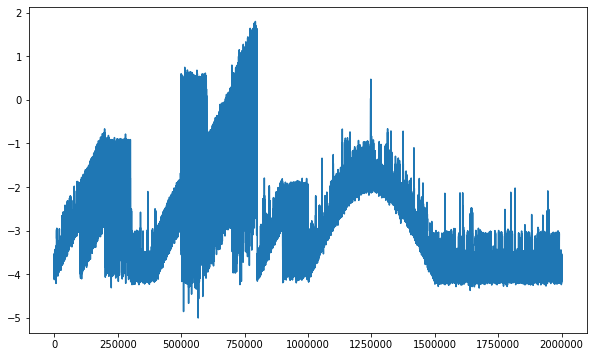

In [37]:
test.signal.plot(figsize=(10,6))
plt.show()

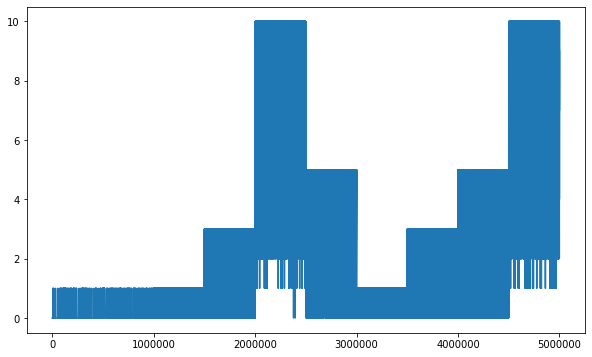

In [17]:
train.open_channels.plot(figsize=(10,6))
plt.show()

## Возьмем последниe миллион из train

In [18]:
train_tail = train.iloc[train.index >= 4500000]

In [20]:
train_tail.shape

(500000, 3)

In [25]:
train_tail['open_channels'].value_counts()

7     132696
8     121940
6      95333
9      66470
5      46556
10     17505
4      15357
3       3513
2        561
1         69
Name: open_channels, dtype: int64

In [26]:
train_tail.to_csv('data/train_tail.csv')

## Теперь память должна выдержать 

In [5]:
train = pd.read_csv('data/train_tail.csv')

In [6]:
test = pd.read_csv('data/test.csv')

In [7]:
train = train.drop(columns = ['Unnamed: 0'])

In [8]:
train.head()

,time,signal,open_channels
0,450.0001,6.6426,10
1,450.0002,7.0135,10
2,450.0003,6.3514,10
3,450.0004,7.1669,10
4,450.0005,7.3763,10


## LGBM

In [9]:
!pip install tensorflow_addons
import tensorflow as tf
from tensorflow.keras.layers import *
import pandas as pd
import numpy as np
import random
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import losses, models, optimizers
import tensorflow_addons as tfa
import gc

from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

import os

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [10]:
# configurations and main hyperparammeters
EPOCHS = 180
NNBATCHSIZE = 16
GROUP_BATCH_SIZE = 4000
SEED = 321
LR = 0.0015
SPLITS = 6

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [11]:
# create batches of 4000 observations
def batching(df, batch_size):
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
    return df

# normalize the data (standard scaler). We can also try other scalers for a better score!
def normalize(train, test):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean) / train_input_sigma
    test['signal'] = (test.signal - train_input_mean) / train_input_sigma
    return train, test

# get lead and lags features
def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
    return df

# main module to run feature engineering. Here you may want to try and add other features and check if your score imporves :).
def run_feat_engineering(df, batch_size):
    # create batches
    df = batching(df, batch_size = batch_size)
    # create leads and lags (1, 2, 3 making them 6 features)
    df = lag_with_pct_change(df, [1, 2, 3])
    # create signal ** 2 (this is the new feature)
    df['signal_2'] = df['signal'] ** 2
    return df

# fillna with the mean and select features for training
def feature_selection(train, test):
    features = [col for col in train.columns if col not in ['index', 'group', 'open_channels', 'time']]
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = pd.concat([train[feature], test[feature]], axis = 0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features

In [12]:
train, test = normalize(train, test)

In [13]:
train = run_feat_engineering(train, batch_size = GROUP_BATCH_SIZE)
test = run_feat_engineering(test, batch_size = GROUP_BATCH_SIZE)
train, test, features = feature_selection(train, test)

In [14]:
train.head()

,time,signal,open_channels,group,signal_shift_pos_1,signal_shift_neg_1,signal_shift_pos_2,signal_shift_neg_2,signal_shift_pos_3,signal_shift_neg_3,signal_2
0,450.0001,0.061992,10,0,0.000000,0.216728,0.000000,-0.059494,0.000000,0.280725,0.003843
1,450.0002,0.216728,10,0,0.061992,-0.059494,0.000000,0.280725,0.000000,0.368084,0.046971
2,450.0003,-0.059494,10,0,0.216728,0.280725,0.061992,0.368084,0.000000,0.611431,0.003540
3,450.0004,0.280725,10,0,-0.059494,0.368084,0.216728,0.611431,0.061992,-0.008013,0.078806
4,450.0005,0.368084,10,0,0.280725,0.611431,-0.059494,-0.008013,0.216728,0.393449,0.135486


In [15]:
test.head()

,time,signal,group,signal_shift_pos_1,signal_shift_neg_1,signal_shift_pos_2,signal_shift_neg_2,signal_shift_pos_3,signal_shift_neg_3,signal_2
0,500.0001,-3.814704,0,0.000000,-3.897975,0.000000,-3.902398,0.000000,-3.725092,14.551969
1,500.0002,-3.897975,0,-3.814704,-3.902398,0.000000,-3.725092,0.000000,-3.800395,15.194213
2,500.0003,-3.902398,0,-3.897975,-3.725092,-3.814704,-3.800395,0.000000,-3.779702,15.228708
3,500.0004,-3.725092,0,-3.902398,-3.800395,-3.897975,-3.779702,-3.814704,-3.851417,13.876310
4,500.0005,-3.800395,0,-3.725092,-3.779702,-3.902398,-3.851417,-3.897975,-3.868522,14.443000


In [16]:
train.shape, test.shape

((500000, 11), (2000000, 10))

In [17]:
train['signal_rolling_mean_1h'] = train['signal'].rolling(window = 100).mean().fillna(0)
test['signal_rolling_mean_1h'] = test['signal'].rolling(window = 100).mean().fillna(0)

train['signal_rolling_std_1h'] = train['signal'].rolling(window = 100).std().fillna(0)
test['signal_rolling_std_1h'] = test['signal'].rolling(window = 100).std().fillna(0)

train['signal_rolling_median_1h'] = train['signal'].rolling(window = 100).median().fillna(0)
test['signal_rolling_median_1h'] = test['signal'].rolling(window = 100).median().fillna(0)

#
train['signal_rolling_mean_1t'] = train['signal'].rolling(window = 1000).mean().fillna(0)
test['signal_rolling_mean_1t'] = test['signal'].rolling(window = 1000).mean().fillna(0)

train['signal_rolling_std_1t'] = train['signal'].rolling(window = 1000).std().fillna(0)
test['signal_rolling_std_1t'] = test['signal'].rolling(window = 1000).std().fillna(0)

train['signal_rolling_median_1t'] = train['signal'].rolling(window = 1000).median().fillna(0)
test['signal_rolling_median_1t'] = test['signal'].rolling(window = 1000).median().fillna(0)

# #
# train['signal_rolling_mean_3h'] = train['signal'].rolling(window = 333).mean().fillna(0)
# test['signal_rolling_mean_3h'] = test['signal'].rolling(window = 333).mean().fillna(0)

# train['signal_rolling_std_3h'] = train['signal'].rolling(window = 333).std().fillna(0)
# test['signal_rolling_std_3h'] = test['signal'].rolling(window = 333).std().fillna(0)

# train['signal_rolling_median_3h'] = train['signal'].rolling(window = 333).median().fillna(0)
# test['signal_rolling_median_3h'] = test['signal'].rolling(window = 333).median().fillna(0)

train['shift_100'] = train['signal'].shift(100)
train['shift_1000'] = train['signal'].shift(1000)

test['shift_100'] = test['signal'].shift(100)
test['shift_1000'] = test['signal'].shift(1000)

In [18]:
train.head()

,time,signal,open_channels,group,signal_shift_pos_1,signal_shift_neg_1,signal_shift_pos_2,signal_shift_neg_2,signal_shift_pos_3,signal_shift_neg_3,signal_2,signal_rolling_mean_1h,signal_rolling_std_1h,signal_rolling_median_1h,signal_rolling_mean_1t,signal_rolling_std_1t,signal_rolling_median_1t,shift_100,shift_1000
0,450.0001,0.061992,10,0,0.000000,0.216728,0.000000,-0.059494,0.000000,0.280725,0.003843,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,450.0002,0.216728,10,0,0.061992,-0.059494,0.000000,0.280725,0.000000,0.368084,0.046971,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,450.0003,-0.059494,10,0,0.216728,0.280725,0.061992,0.368084,0.000000,0.611431,0.003540,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,450.0004,0.280725,10,0,-0.059494,0.368084,0.216728,0.611431,0.061992,-0.008013,0.078806,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,450.0005,0.368084,10,0,0.280725,0.611431,-0.059494,-0.008013,0.216728,0.393449,0.135486,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Модели

In [25]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X = train.drop(['time', 'open_channels'], axis = 1)
y = train['open_channels']
X_test = test.drop(['time'], axis = 1)

X_train, X_val, y_train, y_val = train_test_split(X, y)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

lgbm_params = {
    'objective': 'multiclass',
    'num_class': 11}

model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval)
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)

[1]	valid_0's multi_logloss: 1.58061
[2]	valid_0's multi_logloss: 1.45857
[3]	valid_0's multi_logloss: 1.38257
[4]	valid_0's multi_logloss: 1.2952
[5]	valid_0's multi_logloss: 1.22341
[6]	valid_0's multi_logloss: 1.16027
[7]	valid_0's multi_logloss: 1.10626
[8]	valid_0's multi_logloss: 1.0653
[9]	valid_0's multi_logloss: 1.0011
[10]	valid_0's multi_logloss: 0.959574
[11]	valid_0's multi_logloss: 0.920977
[12]	valid_0's multi_logloss: 0.889186
[13]	valid_0's multi_logloss: 0.854832
[14]	valid_0's multi_logloss: 0.82497
[15]	valid_0's multi_logloss: 0.87443
[16]	valid_0's multi_logloss: 0.805046
[17]	valid_0's multi_logloss: 0.791329
[18]	valid_0's multi_logloss: 0.757852
[19]	valid_0's multi_logloss: 0.736952
[20]	valid_0's multi_logloss: 0.72579
[21]	valid_0's multi_logloss: 0.716802
[22]	valid_0's multi_logloss: 0.69796
[23]	valid_0's multi_logloss: 0.692
[24]	valid_0's multi_logloss: 0.679859
[25]	valid_0's multi_logloss: 0.677115
[26]	valid_0's multi_logloss: 0.655893
[27]	valid_0's

In [29]:
y_pred_max_train = np.argmax(model.predict(X), axis=1)

In [36]:
y_pred_max_train.shape, y.shape

((500000,), (500000,))

In [37]:
from sklearn.metrics import f1_score

In [41]:
f1_score(y_pred_max_train, y, average='macro')

0.7018874278327012

In [44]:
y.value_counts()

7     132696
8     121940
6      95333
9      66470
5      46556
10     17505
4      15357
3       3513
2        561
1         69
Name: open_channels, dtype: int64

In [47]:
errors = (y != y_pred_max_train) * y

In [50]:
errors.value_counts()

0     431990
7      16982
8      14946
6      13168
9       8942
5       6923
4       2866
10      2788
3       1025
2        301
1         69
Name: open_channels, dtype: int64

In [57]:
errors = pd.DataFrame(errors)

In [67]:
err_index = errors.loc[errors.open_channels != 0].index.values

In [1]:
plt.hist(err_index, bins=20)
plt.show()

NameError: name 'plt' is not defined

## Другие целевые функции

In [19]:
def weighted_tail(y_hat, dtrain):
    y = dtrain.get_label()
    #y_hat = np.clip(y_hat, 10e-7, 1-10e-7)
    #print(y.shape, y_hat.shape)
    return 'loss 1: ', np.sum(np.arange(len(y)) * (y - y_hat) ** 2)  , False

0

In [21]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X = train.drop(['time', 'open_channels'], axis = 1)
y = train['open_channels']
X_test = test.drop(['time'], axis = 1)

X_train, X_val, y_train, y_val = train_test_split(X, y)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

lgbm_params = {
    'objective': 'regression'}
    #'num_class': 11}

model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, feval = weighted_tail)
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
#y_pred_max = np.argmax(y_pred, axis=1)

[1]	valid_0's l2: 1.73812	valid_0's loss 1: : 1.35767e+10
[2]	valid_0's l2: 1.46637	valid_0's loss 1: : 1.14508e+10
[3]	valid_0's l2: 1.24237	valid_0's loss 1: : 9.70027e+09
[4]	valid_0's l2: 1.05682	valid_0's loss 1: : 8.24958e+09
[5]	valid_0's l2: 0.904637	valid_0's loss 1: : 7.05946e+09
[6]	valid_0's l2: 0.776935	valid_0's loss 1: : 6.061e+09
[7]	valid_0's l2: 0.673356	valid_0's loss 1: : 5.25206e+09
[8]	valid_0's l2: 0.587384	valid_0's loss 1: : 4.5804e+09
[9]	valid_0's l2: 0.514356	valid_0's loss 1: : 4.00964e+09
[10]	valid_0's l2: 0.453663	valid_0's loss 1: : 3.53494e+09
[11]	valid_0's l2: 0.402965	valid_0's loss 1: : 3.13873e+09
[12]	valid_0's l2: 0.361076	valid_0's loss 1: : 2.81157e+09
[13]	valid_0's l2: 0.325009	valid_0's loss 1: : 2.53001e+09
[14]	valid_0's l2: 0.294393	valid_0's loss 1: : 2.29153e+09
[15]	valid_0's l2: 0.268992	valid_0's loss 1: : 2.09355e+09
[16]	valid_0's l2: 0.247277	valid_0's loss 1: : 1.92419e+09
[17]	valid_0's l2: 0.228607	valid_0's loss 1: : 1.7786e+

In [27]:
y_pred_max_train = np.round(model.predict(X))

In [28]:
y_pred_max_train.shape

(500000,)

In [29]:
from sklearn.metrics import f1_score

In [32]:
f1_score(y_pred_max_train, y, average='macro')

0.7671985950276308

## Улучшили на 6% качество на train. Попробуем применить это ко всему набору данных

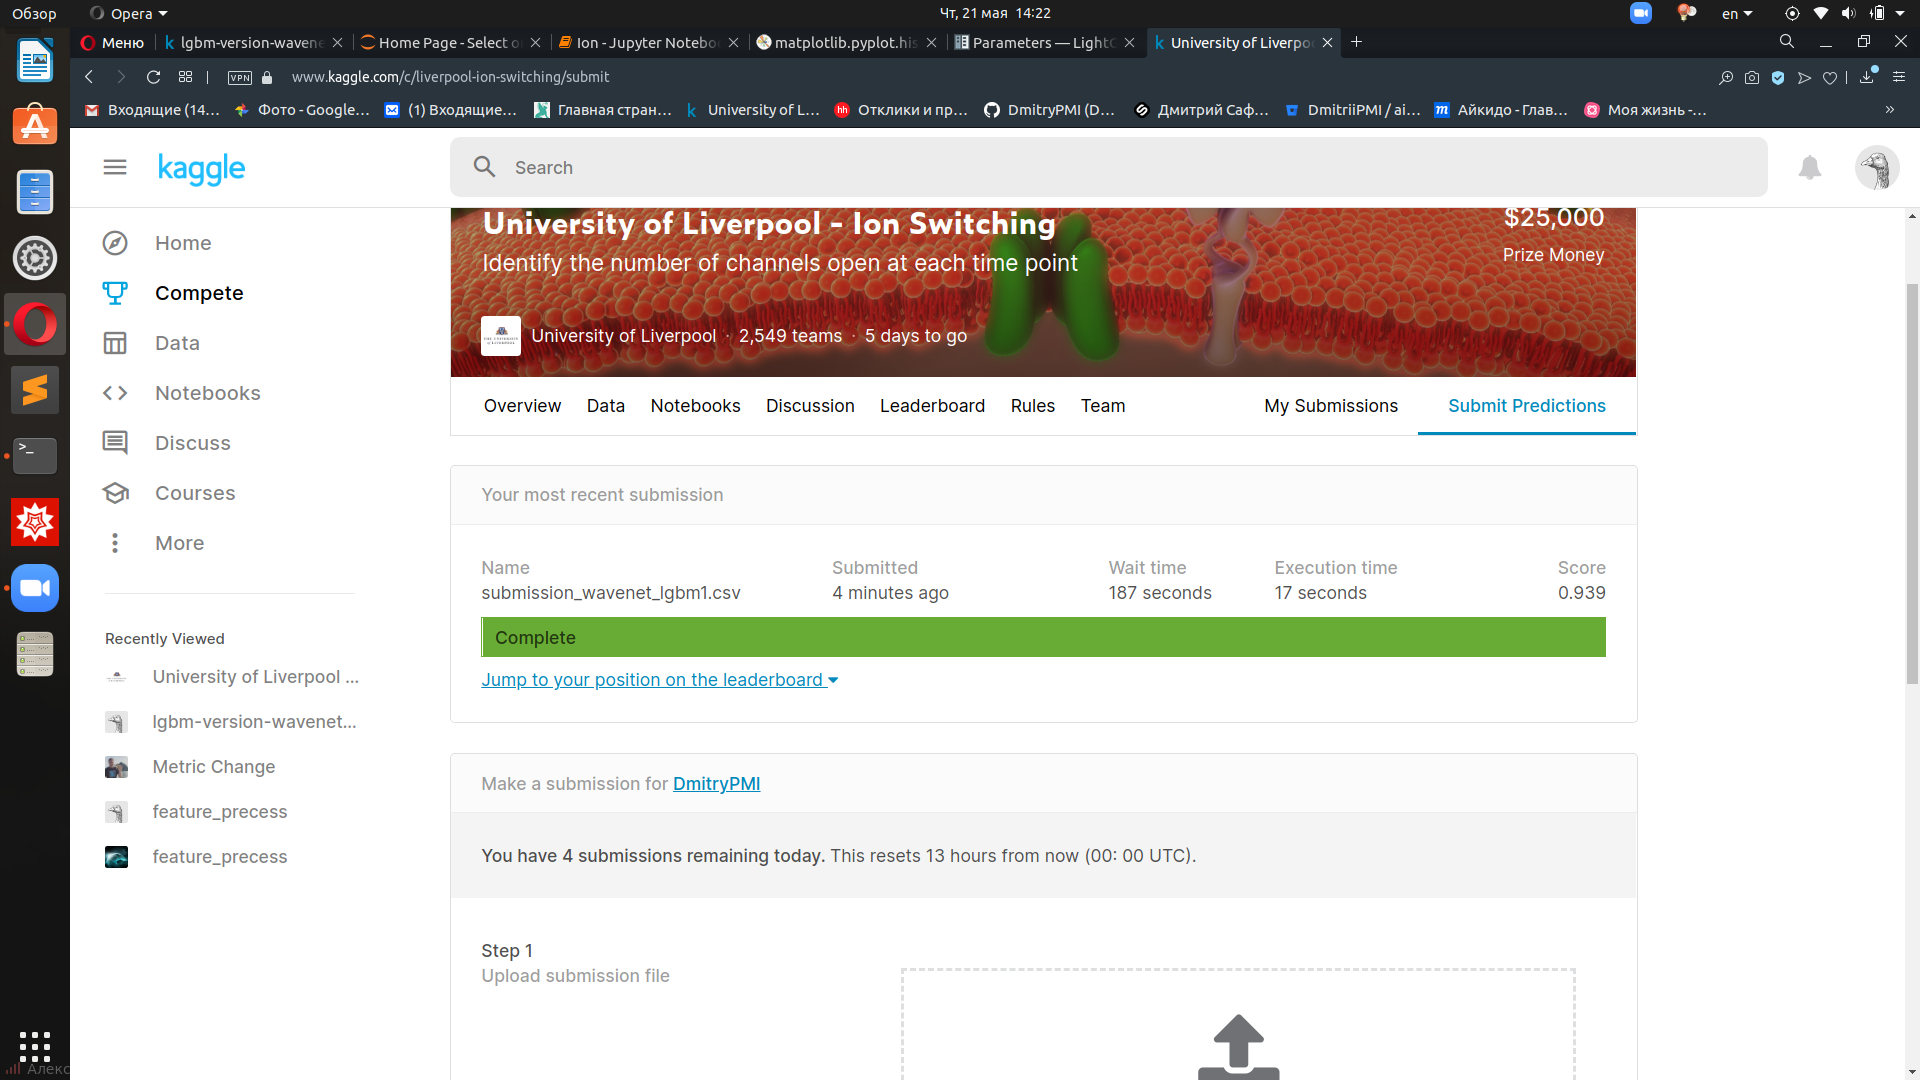

## На public leaderboard я ухудшил качество на 1%